## Introduction

In [5]:
# import general use libraries
import numpy as np
import matplotlib.pyplot as plt

In [1]:
# import libraries for pagerank testing
from libs.cython.pyx.utils import list2matrix
from libs.cython.pyx.edgelistParser import edgelistParser
from libs.cython.cpp.pageRankCpp import cppGetDegree, cppLocalPageRank_weight, cppLocalPageRank, cppApproximateSimrank

In [6]:
# load a dataset, in both weighted and unweighted forms
A_weighted, N, original_idxs = edgelistParser("../datasets/facebook/0.edges", "raw_list", True)
A, _, _ = edgelistParser("../datasets/facebook/0.edges", "raw_list", False)

In [10]:
# test performance on both verions
print("Weighted version, slower:")
%timeit cppLocalPageRank_weight(A_weighted, c=0.85, return_only_neighbours=True)
print("Unweighted version, faster:")
%timeit cppLocalPageRank(A, c=0.85, return_only_neighbours=True)

Weighted version, slower:
601 ms ± 5.97 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Unweighted version, faster:
94.1 ms ± 239 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Difference between Local PageRank Computations: 0.0


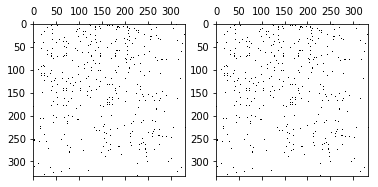

In [11]:
# generate the L matrix, assuming both weighted and unweighted input
L_weighted = cppLocalPageRank_weight(A_weighted, c=0.85, return_only_neighbours=True)
L = cppLocalPageRank(A, c=0.85, return_only_neighbours=True)

# convert to numpy matrix, to visually check the results
L_weighted_mat = list2matrix(L_weighted)
L_mat = list2matrix(L)

# plot the matrices' spy 
fig, axs = plt.subplots(1, 2)
axs[0].spy(L_weighted_mat)
axs[1].spy(L_mat)

# and print the difference to check that the same result was obtained
print("Difference between Local PageRank Computations:", np.linalg.norm(L_mat-L_weighted_mat))

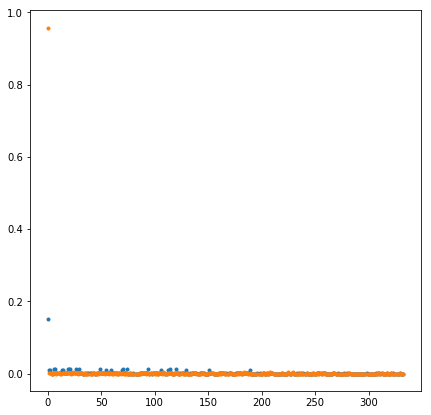

In [17]:
# now compute the approximate simrank to check the correctness of the algorithm
c = .85;
alpha = 2*c/(1+c);
#andersen's paper inverts alpha
alpha = 1-alpha;

v = 0

# compute using fast algorithm
p, r = cppApproximateSimrank(A, v, alpha)

# compute the linear system solution of the lazy pagerank
A_mat = list2matrix(A, False)
# compute the degree
d = np.dot(A_mat, np.ones((N, 1)))
# compute W (lazy pagerank matrix): W = .5(I+M)
# where M = D^-1 * A
M = np.matmul(np.diagflat(1/d), A_mat)
W = .5*(np.eye(N)+M)
# initialize the teleportation vector
q = np.zeros((N, 1))
q[v] = 1
# finally compute the actual vector: p = alpha*W*p + (1 - alpha)q
p_s = np.dot(np.linalg.inv((np.eye(N)-alpha*W)/(1-alpha)), q).flatten()

# compute pagerank using the residuals
p_r = np.dot(np.linalg.inv((np.eye(N)-alpha*W)/(1-alpha)), r).flatten()

# plot results
fig, axs = plt.subplots(1, 1, figsize=(7,7))
axs.plot(p + p_r, '.')
axs.plot(p_s, '.')